In [1]:
%config IPCompleter.greedy=True
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D
from pathlib import Path
import numpy as np
import os
import shutil

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.test.gpu_device_name()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3086503732366720075
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17965845293876325522
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9434324353268708497
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10076589261
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3261329001355792884
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'/device:GPU:0'

In [2]:
DIR_IN = '/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/'

In [3]:
crack_dirs = []
noncrack_dirs = []
for path in Path(DIR_IN).glob('**'):
    if path.stem[0] == 'U':
        noncrack_dirs.append(path)
    elif path.stem[0] == 'C':
        crack_dirs.append(path)

In [4]:
crack_dirs

[PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/D/CD'),
 PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/P/CP'),
 PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/W/CW')]

In [5]:
noncrack_dirs

[PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/D/UD'),
 PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/P/UP'),
 PosixPath('/home/khanhhh/data_1/courses/practical_project_1/codes/dataset/SDNET2018/W/UW')]

In [6]:
crack_paths = []
noncrack_paths = []
for dir in crack_dirs:
    for path in dir.glob('*.*'):
        crack_paths.append(path)
        
for dir in noncrack_dirs:
    for path in dir.glob('*.*'):
        noncrack_paths.append(path)
        
all_paths = crack_paths + noncrack_paths
n = len(all_paths)
n_crack = len(crack_paths)
n_noncrack = n - n_crack

In [7]:
labels  = np.zeros(n, dtype=np.bool)
labels[:n_crack] = 1
labels[n_crack:] = 0
indices = np.arange(n)

rng = np.random.RandomState()
indices = rng.permutation(indices)
train_size, valid_size= int(0.65*n), int(0.15*n)
test_size = n - train_size - valid_size

train_ind = indices[:train_size]
valid_ind = indices[train_size:(train_size+valid_size)]
test_ind  = indices[(train_size+valid_size):]

print(n,':', train_size, valid_size, test_size)

TRAIN_DIR = f'{DIR_IN}/train/'
VALID_DIR = f'{DIR_IN}/valid/'
TEST_DIR  = f'{DIR_IN}/test/'

56092 : 36459 8413 11220


In [9]:
shutil.rmtree(TRAIN_DIR)
shutil.rmtree(VALID_DIR)
shutil.rmtree(TEST_DIR)

os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(VALID_DIR, exist_ok = True)
os.makedirs(TEST_DIR,  exist_ok = True)

os.makedirs(f'{TRAIN_DIR}crack', exist_ok = True)
os.makedirs(f'{TRAIN_DIR}noncrack', exist_ok = True)
os.makedirs(f'{VALID_DIR}crack', exist_ok = True)
os.makedirs(f'{VALID_DIR}noncrack', exist_ok = True)
os.makedirs(f'{TEST_DIR}crack', exist_ok = True)
os.makedirs(f'{TEST_DIR}noncrack', exist_ok = True)

In [10]:
for idx in train_ind:
    path = all_paths[idx]
    if labels[idx] == 1:
        shutil.copy(path, f'{TRAIN_DIR}/crack/{path.name}')
    else:
        shutil.copy(path, f'{TRAIN_DIR}/noncrack/{path.name}')
    
for idx in valid_ind:
    path = all_paths[idx]
    if labels[idx] == 1:
        shutil.copy(path, f'{VALID_DIR}/crack/{path.name}')
    else:
        shutil.copy(path, f'{VALID_DIR}/noncrack/{path.name}')
    
for idx in test_ind:
    path = all_paths[idx]
    if labels[idx] == 1:
        shutil.copy(path, f'{TEST_DIR}/crack/{path.name}')
    else:
        shutil.copy(path, f'{TEST_DIR}/noncrack/{path.name}')

In [58]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')
print('train batches per epoch: ', len(train_generator))
print('valid batches per epoch: ', len(validation_generator))

Found 36459 images belonging to 2 classes.
Found 8413 images belonging to 2 classes.
train batches per epoch:  365
valid batches per epoch:  85


In [40]:
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224,224),
        batch_size=100,
        class_mode='categorical')

print('test batches: ', len(test_generator))

Found 11220 images belonging to 2 classes.
test len:  113


In [30]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization, Dropout
from keras import optimizers
from keras.regularizers import l2


# (3) Create a sequential model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_26 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_27 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 256)         0         
__________

In [57]:
from keras.callbacks import ModelCheckpoint

n_epochs = 20

model_path = f'{DIR_IN}/models/best_weight.hdf5'
check_point = ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=n_epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator))

Epoch 1/20
365/365 [==============================] - 58s 159ms/step - loss: 0.4013 - acc: 0.8513 - val_loss: 0.4246 - val_acc: 0.8449
Epoch 2/20
365/365 [==============================] - 56s 154ms/step - loss: 0.3955 - acc: 0.8511 - val_loss: 0.5114 - val_acc: 0.8498
Epoch 3/20
365/365 [==============================] - 56s 153ms/step - loss: 0.3919 - acc: 0.8532 - val_loss: 0.4860 - val_acc: 0.8360
Epoch 4/20
365/365 [==============================] - 57s 157ms/step - loss: 0.3859 - acc: 0.8547 - val_loss: 0.3900 - val_acc: 0.8521
Epoch 5/20
365/365 [==============================] - 57s 155ms/step - loss: 0.3894 - acc: 0.8521 - val_loss: 0.5477 - val_acc: 0.8506
Epoch 6/20
365/365 [==============================] - 57s 157ms/step - loss: 0.3815 - acc: 0.8556 - val_loss: 0.4247 - val_acc: 0.8527
Epoch 7/20
365/365 [==============================] - 57s 156ms/step - loss: 0.3754 - acc: 0.8576 - val_loss: 0.4020 - val_acc: 0.8546
Epoch 8/20
365/365 [==============================] - 5

In [59]:
model.save(f'{DIR_IN}/models/model.hdf5')

In [60]:
from keras.models import load_model
model = load_model(f'{DIR_IN}/models/model.hdf5')

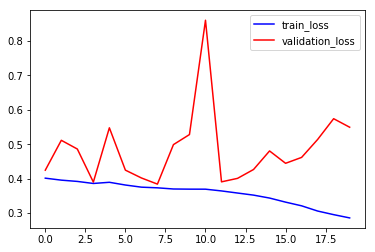

In [61]:
import matplotlib.pyplot as plt
x = np.arange(n_epochs)
plt.plot(x, history.history['loss'], '-b', label = 'train_loss')
plt.plot(x, history.history['val_loss'], '-r', label='validation_loss')
plt.legend()

In [62]:
preds = model.predict_generator(test_generator, steps=len(test_generator))

In [69]:
preds_idx = np.argmax(preds, axis=1) #multiple categories

In [70]:
correct_preds = preds_idx == test_generator.classes

In [71]:
import numpy as np
acc = (np.sum(correct_preds)/len(preds_idx))
print(f'accuracy = {acc}')

accuracy = 0.830837789661319
